In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import os
from tqdm.notebook import trange, tqdm

from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kruskal
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, precision_score, accuracy_score, plot_roc_curve, roc_auc_score

C:\Users\ygshe\anaconda3\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\ygshe\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Split data to training and testing set

In [2]:
# Get proper file path separator for current OS
s = os.path.sep

In [3]:
# Import original data
auto = pd.read_csv("D:" + s + "2022 Spring" + s + "ISYE7406" + s + "HW" + s + "HW3" + s + "Auto.csv")

In [4]:
# Calculate the median of mpg column
mpg_median = auto['mpg'].median()

In [5]:
# Add new column, mpg01, as the response variable in this project
# mpg01 = 1 if mpg >= mpg_median, 0 otherwise
auto['mpg01'] = (auto['mpg'] >= mpg_median).astype(int)

In [6]:
# Use 30% (118 cases) as testing set. Keep the ratio of 1 and 0 as 50% each when sampling. 
test = auto.groupby('mpg01', group_keys = False).apply(lambda x: x.sample(frac = 0.3, random_state = 7406))

In [7]:
# Use the rest 70% (274 cases) as training set
train = auto.drop(labels = test.index)

# Perform EDA on training set

## Histogram, boxplot, descriptive stats for continuous variables

In [8]:
# Divide the variables into continuous and discrete
cont_vars = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']
disc_vars = ['cylinders', 'year', 'origin']

In [9]:
# Descriptive stats for continuous variables
train_cont = train[cont_vars]

In [10]:
print(tabulate(train_cont.describe(), headers = 'keys', tablefmt='grid', stralign='center'))

+-------+-----------+----------------+--------------+----------+----------------+
|       |       mpg |   displacement |   horsepower |   weight |   acceleration |
+=======+===========+================+==============+==========+================+
| count | 274       |        274     |     274      |  274     |      274       |
+-------+-----------+----------------+--------------+----------+----------------+
| mean  |  23.4223  |        192.436 |     104.434  | 2960.92  |       15.4526  |
+-------+-----------+----------------+--------------+----------+----------------+
|  std  |   7.63295 |        104.86  |      38.9279 |  854.812 |        2.61508 |
+-------+-----------+----------------+--------------+----------+----------------+
|  min  |  10       |         68     |      46      | 1613     |        8       |
+-------+-----------+----------------+--------------+----------+----------------+
|  25%  |  17       |        105     |      76      | 2226.5   |       14       |
+-------+-------

In [11]:
# Standardize the continuous variables in training data
train_cont_std = (train_cont - train_cont.mean()) / train_cont.std()

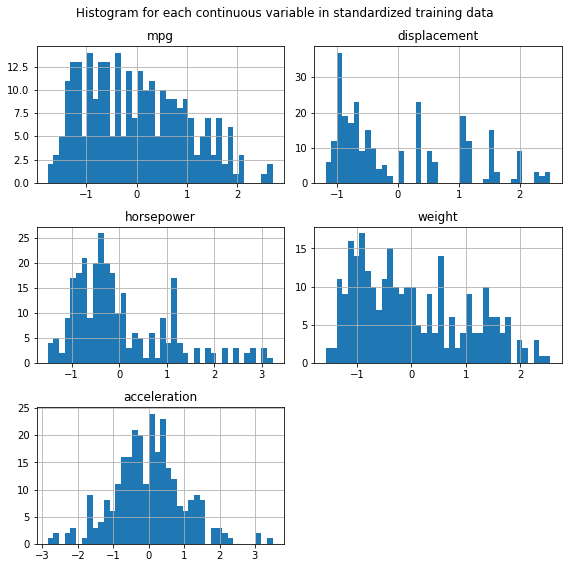

In [12]:
# Show histogram for each of standardized continuous variables in training set
train_cont_std.hist(bins = 40, figsize = (8, 8))
plt.suptitle('Histogram for each continuous variable in standardized training data')
plt.tight_layout()


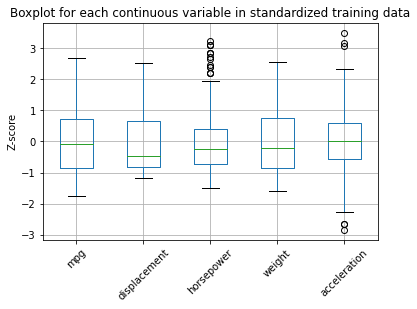

In [13]:
# Show the box plot for each of the standardized continuous variable in training set
train_cont_std.boxplot()
plt.xticks(rotation=45)
plt.ylabel('Z-score')
plt.title('Boxplot for each continuous variable in standardized training data')
plt.show()


## Potential outliers

In [14]:
# Write a function to display outlier data entries
def show_outlier(df, z_score):
    # Standardize the input dataframe
    df_std = (df - df.mean()) / df.std()
    # Check each row to look for outlier based on z_score criteria input by the user
    df_std['is_outlier'] = (abs(df_std) > z_score).sum(axis = 1)
    # Select the outliers from standardized data
    outliers = df_std.loc[df_std['is_outlier'] != 0].drop('is_outlier', axis = 1)
    # Make the outliers pretty
    styler = outliers.style
    styler.set_caption("Display Outliers after Standardization")
    styler.format(precision = 2).apply(lambda x: ["background: yellow" if abs(v) > z_score else "" for v in x], axis = 1)
    
    return styler


In [15]:
show_outlier(train_cont, 3)

,mpg,displacement,horsepower,weight,acceleration
8,-1.23,2.50,3.10,1.71,-2.09
13,-1.23,2.50,3.10,0.15,-2.09
58,-0.06,-0.91,-1.30,-0.83,3.08
94,-1.50,2.50,3.10,2.33,-1.70
115,-0.97,1.98,3.23,1.54,-2.28
324,2.62,-0.98,-1.45,-0.73,3.15
388,2.70,-0.91,-1.35,-0.97,3.50


In [16]:
potential_outliers = list(show_outlier(train_cont, 3).index)

In [17]:
# Display the raw data of potential outliers
auto.iloc[potential_outliers]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
8,14.0,8,455.0,225,4425,10.0,70,1,0
13,14.0,8,455.0,225,3086,10.0,70,1,0
58,23.0,4,97.0,54,2254,23.5,72,2,1
94,12.0,8,455.0,225,4951,11.0,73,1,0
115,16.0,8,400.0,230,4278,9.5,73,1,0
324,43.4,4,90.0,48,2335,23.7,80,2,1
388,44.0,4,97.0,52,2130,24.6,82,2,1


## Normality of individual continuous variable

In [18]:
# Create a function to draw QQ Plot. Take dataframe and column name, str type, as inputs.
def do_qqplot(df, col_name):
    qqplot(df[col_name], ms = 3, line = 's')
    plt.title('Quantile-Quantile Plot for ' + col_name)
    plt.show()

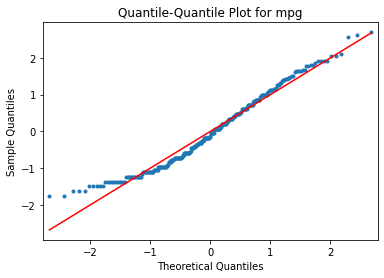

In [19]:
# QQ Plot for 'mpg'
do_qqplot(train_cont_std, 'mpg')

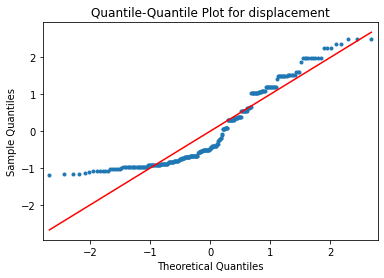

In [20]:
# QQ Plot for 'displacement'
do_qqplot(train_cont_std, 'displacement')

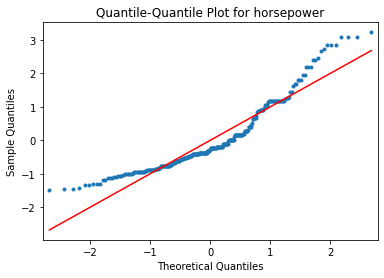

In [21]:
# QQ Plot for 'horsepower'
do_qqplot(train_cont_std, 'horsepower')

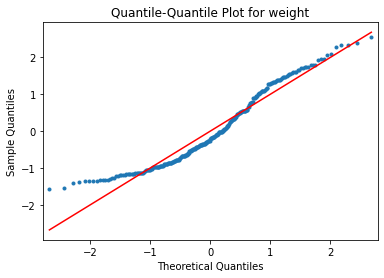

In [22]:
# QQ Plot for 'weight'
do_qqplot(train_cont_std, 'weight')

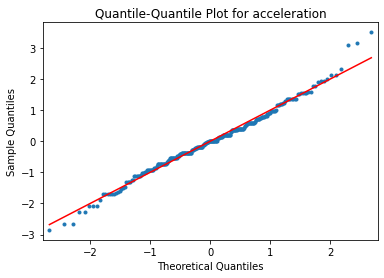

In [23]:
# QQ Plot for 'acceleration'
do_qqplot(train_cont_std, 'acceleration')

In [24]:
# Perform statistical Normality test 
shapiro_p = []
dagostino_p = []
for col in cont_vars:
    shapiro_p.append(shapiro(train_cont_std[col]).pvalue)
    dagostino_p.append(normaltest(train_cont_std[col]).pvalue)

In [25]:
# Create a dataframe to show the p values of Normality test

norm_test = pd.DataFrame(zip(shapiro_p, dagostino_p), index = cont_vars, columns=['Shapiro-Wilk Test', 'DAgostino K^2 Test'])
norm_test

,Shapiro-Wilk Test,DAgostino K^2 Test
mpg,9.665255e-06,9.062757e-05
displacement,4.013353e-14,7.870516e-08
horsepower,6.198927e-13,5.516363e-12
weight,4.102021e-09,1.922053e-07
acceleration,7.185285e-02,5.689222e-02


In [26]:
print(tabulate(norm_test, headers = 'keys', tablefmt='grid', stralign='center'))

+--------------+---------------------+----------------------+
|              |   Shapiro-Wilk Test |   DAgostino K^2 Test |
+==============+=====================+======================+
|     mpg      |         9.66525e-06 |          9.06276e-05 |
+--------------+---------------------+----------------------+
| displacement |         4.01335e-14 |          7.87052e-08 |
+--------------+---------------------+----------------------+
|  horsepower  |         6.19893e-13 |          5.51636e-12 |
+--------------+---------------------+----------------------+
|    weight    |         4.10202e-09 |          1.92205e-07 |
+--------------+---------------------+----------------------+
| acceleration |         0.0718528   |          0.0568922   |
+--------------+---------------------+----------------------+


## Scatter plot of continuous variables VS mpg

In [27]:
# Create a function to generate scatter plot of two variables together with Pearson Correlaitona and p-value
def do_scatter(x, y, data):
    # Calculate Pearson correlaiton
    pearson_result = pearsonr(data[x], data[y])
    pearson_r = pearson_result[0]
    pearson_p = pearson_result[1]
    
    # Calculate Spearman correlation
    spearman_result = spearmanr(data[x], data[y])
    spearman_rho = spearman_result[0]
    spearman_p = spearman_result[1]
    
    # Draw the plot
    sns.scatterplot(x = x, y = y, data = data)
    # Add title and two correlations to the plot
    title = y+' V.S. '+x+'\n'+'Pearson_r = {:.2f}, p = {:.2g}'.format(pearson_r, pearson_p)+'\n'+'Spearman_rho = {:.2f}, p = {:.2g}'.format(spearman_rho, spearman_p) 
    plt.title(title)
    plt.show()

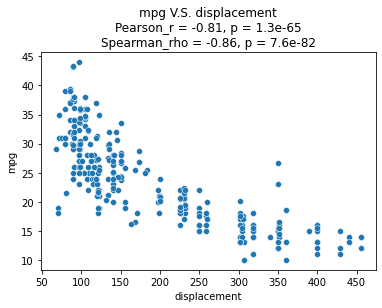

In [28]:
# mpg vs displacement
do_scatter(x = 'displacement', y = 'mpg', data = train)

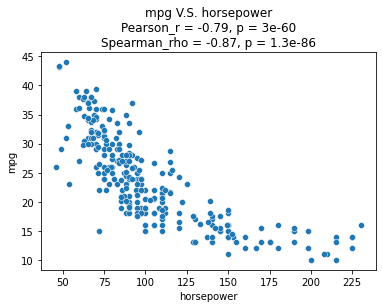

In [29]:
# mpg vs horsepower
do_scatter(x = 'horsepower', y = 'mpg', data = train)

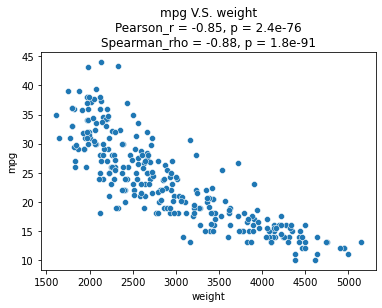

In [30]:
# mpg vs weight
do_scatter(x = 'weight', y = 'mpg', data = train)

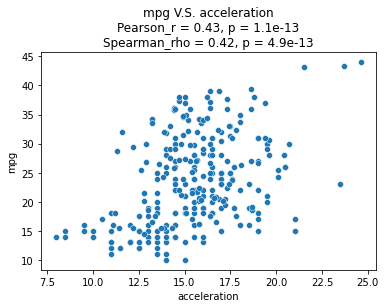

In [31]:
# mpg vs acceleration
do_scatter(x = 'acceleration', y = 'mpg', data = train)

## Discrete variables: cylinders, origin, year

## Simply count the cases 

In [32]:
# Create a function to count cases based on the dicrete variable
def do_count(x, data):
    fig = sns.countplot(x = x, data = data)
    plt.bar_label(fig.containers[0])
    plt.title('Number of cars counted by ' + x)
    plt.show()

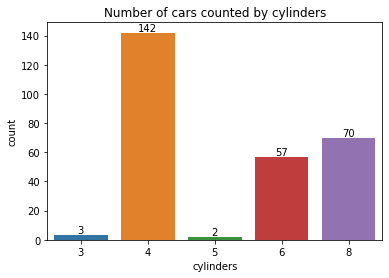

In [33]:
# Count by number of cylinders
do_count('cylinders', data = train)

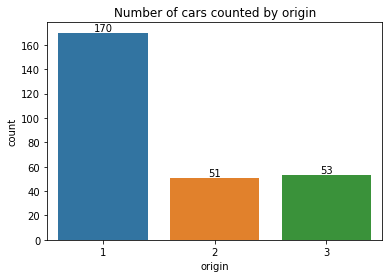

In [34]:
# Count by origin
do_count('origin', data = train)

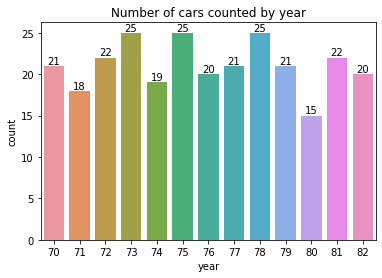

In [35]:
# Count by model year
do_count('year', data = train)

## Compare mpg based on discrete variable

In [36]:
# Create a function to draw boxplot of mpg based on the discrete variable
def do_boxplot(x, y, data):
    sns.violinplot(x = x, y = y, data = data)
    plt.title(y + ' V.S. ' + x)
    plt.show()

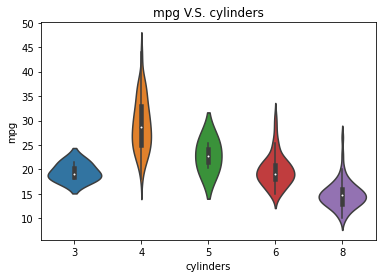

In [37]:
# mpg vs cylinders
do_boxplot(x = 'cylinders', y = 'mpg', data = train)

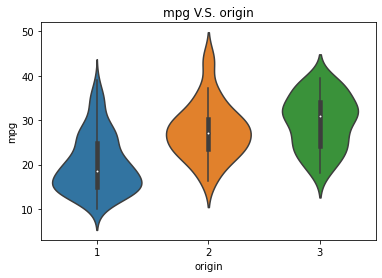

In [38]:
# mpg vs origin
do_boxplot(x = 'origin', y = 'mpg', data = train)

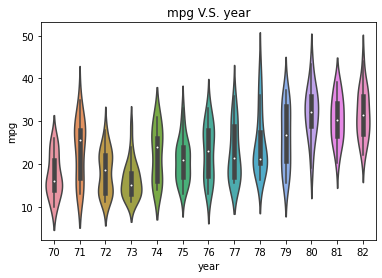

In [39]:
# mpg vs year
do_boxplot(x = 'year', y = 'mpg', data = train)

In [40]:
# Perform Kruskal-Wallis H Test for cylinders
kruskal_result = {'cylinders':[], 'cylinders_no35':[], 'origin':[], 'year':[]}
gb_cyl = train.groupby('cylinders')['mpg']
kruskal_result['cylinders'].append(kruskal(gb_cyl.get_group(3), gb_cyl.get_group(4), 
                                           gb_cyl.get_group(5), gb_cyl.get_group(6), gb_cyl.get_group(8)).pvalue)
kruskal_result['cylinders_no35'].append(kruskal(gb_cyl.get_group(4), gb_cyl.get_group(6), gb_cyl.get_group(8)).pvalue)

In [41]:
# Perform Kruskal-Wallis H Test for origin
gb_orig = train.groupby('origin')['mpg']
kruskal_result['origin'].append(kruskal(gb_orig.get_group(1), gb_orig.get_group(2), gb_orig.get_group(3)).pvalue)

In [42]:
# Perform Kruskal-Wallis H Test for year
gb_year = train.groupby('year')['mpg']
kruskal_result['year'].append(kruskal(gb_year.get_group(70), gb_year.get_group(71), gb_year.get_group(72),
                                     gb_year.get_group(73), gb_year.get_group(74), gb_year.get_group(75),
                                     gb_year.get_group(76), gb_year.get_group(77), gb_year.get_group(78),
                                     gb_year.get_group(79), gb_year.get_group(80), gb_year.get_group(81),
                                     gb_year.get_group(82)).pvalue)

In [43]:
# Show the p-value of Kruskal-Wallis H Test
kw_test = pd.DataFrame(kruskal_result, index = ['Kruskal-Wallis Test p-value'])
kw_test

,cylinders,cylinders_no35,origin,year
Kruskal-Wallis Test p-value,7.126566e-42,7.101676e-43,3.961330e-19,1.388885e-18


## Correlation heatmap

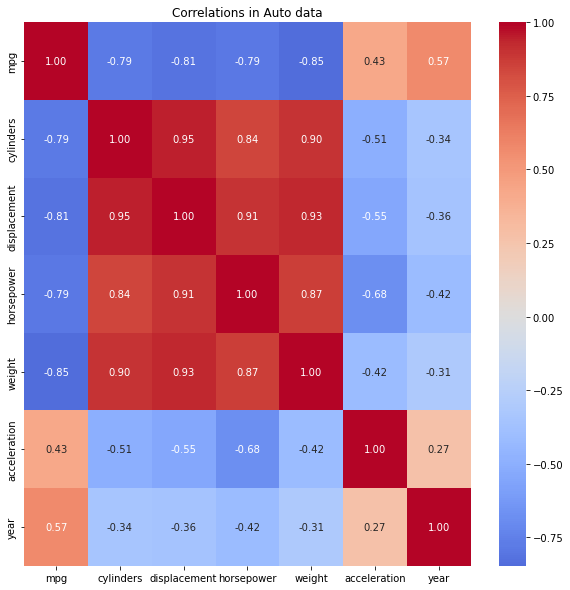

In [44]:
plt.figure(figsize=(10,10))
sns.heatmap(train.drop(['origin', 'mpg01'], axis = 1).corr(), center = 0, cmap = 'coolwarm', annot = True, fmt = '.2f')
plt.title('Correlations in Auto data')
plt.show()

## Two of the three discrete variables still show significant trend

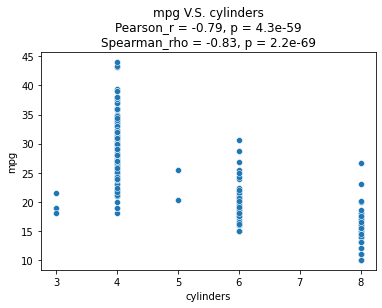

In [45]:
# Try scatterplot of mpg vs cylinders
do_scatter(x = 'cylinders', y = 'mpg', data = train)

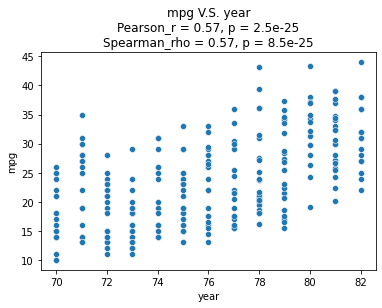

In [46]:
# Try scatterplot of mpg vs year
do_scatter(x = 'year', y = 'mpg', data = train)

## Dummy variable encoding for origin variable using pd.get_dummies()

In [47]:
# Generate dummy variable for origin in training set
train_final = pd.get_dummies(data = train, columns = ['origin'], prefix = ['origin'], drop_first = True)

In [48]:
# Generate dummy variable for origin in testing set
test_final = pd.get_dummies(data = test, columns = ['origin'], prefix = ['origin'], drop_first = True)

## Check multivriate normality using pingouin package

In [49]:
# Define the list of variables
num_vars_only = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
with_cat_vars = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin_2', 'origin_3']
hz_test = {}

In [50]:
# Check multivariate normality for the entire training set
result1 = pg.multivariate_normality(train_final[with_cat_vars], alpha = 0.05)
hz_test['entire_train'] = [result1[1], result1[2]]

In [51]:
# Check multivariate normality for the entire training set, only including numerical variables
result2 = pg.multivariate_normality(train_final[num_vars_only], alpha = 0.05)
hz_test['entire_train_nums_only'] = [result2[1], result2[2]]

In [52]:
# Check multivariate normality for class = 1 in the training set
result3 = pg.multivariate_normality(train_final.groupby('mpg01').get_group(1)[with_cat_vars], alpha = 0.05)
hz_test['class_1_entire_train'] = [result3[1], result3[2]]

In [53]:
# Check multivariate normality for class = 1 in the training set, only including numerical variables
result4 = pg.multivariate_normality(train_final.groupby('mpg01').get_group(1)[num_vars_only], alpha = 0.05)
hz_test['class_1_entire_train_nums_only'] = [result4[1], result4[2]]

In [54]:
# Check multivariate normality for class = 0 in the training set
result5 = pg.multivariate_normality(train_final.groupby('mpg01').get_group(0)[with_cat_vars], alpha = 0.05)
hz_test['class_0_entire_train'] = [result5[1], result5[2]]

In [55]:
# Check multivariate normality for class = 0 in the training set, only including numerical variables
result6 = pg.multivariate_normality(train_final.groupby('mpg01').get_group(0)[num_vars_only], alpha = 0.05)
hz_test['class_0_entire_train_nums_only'] = [result6[1], result6[2]]

In [56]:
# Summarize the Henze-Zirkler Test in a dataframe
hz_df = pd.DataFrame(hz_test, index = ['Henze-Zirkler p-value', 'Multivariate-Normal'])
hz_df

,entire_train,entire_train_nums_only,class_1_entire_train,class_1_entire_train_nums_only,class_0_entire_train,class_0_entire_train_nums_only
Henze-Zirkler p-value,0.0,0.0,0.0,0.0,0.0,0.0
Multivariate-Normal,False,False,False,False,False,False


# Run classification methods using the original train-test split

In [57]:
# Find a way to only standardize numerical variables, but leave dummy variables un-touched
cols_to_std = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year']
cols_to_pass = ['origin_2', 'origin_3']

In [58]:
# Define a ColumnTransformer object, which can be customized to treat each column differently.
ct = ColumnTransformer([('std', StandardScaler(), cols_to_std), ('pass', 'passthrough', cols_to_pass)])

In [59]:
# Seperate predictors and response
train_X = train_final.drop(['mpg', 'mpg01'], axis = 1)
train_Y = train_final['mpg01']

test_X = test_final.drop(['mpg', 'mpg01'], axis = 1)
test_Y = test_final['mpg01']

In [60]:
# Pre-process X values for both training set and testing set
ct.fit(train_X)
train_X_std = ct.transform(train_X)
test_X_std = ct.transform(test_X)

## Some useful functions

In [61]:
# Create a function to show confusion matrix
def show_confusion_matrix(model, model_name, test_X, test_Y, pred_Y):
    
    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(test_Y, pred_Y)

    true_negatives = cf_matrix[0][0]
    false_negatives = cf_matrix[1][0]
    true_positives = cf_matrix[1][1]
    false_positives = cf_matrix[0][1]

    # Calculate classification performance
    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)

    # Show classification performance in a DataFrame
    accu = ['(TN+TP)/(TN+TP+FN+FP)', "{:.4f}".format(float(accuracy))]
    prec = ['TP/(TP+FP)', "{:.4f}".format(float(precision))]
    rec = ['TP/(TP+FN)', "{:.4f}".format(float(recall))]
    spec = ['TN/(TN+FP)', "{:.4f}".format(float(specificity))]
    df = pd.DataFrame({'Accuracy':accu, 'Precision':prec, 'Recall':rec, 'Specificity':spec}, index = ['Formula', 'Value'])

    print(tabulate(df, headers = 'keys', tablefmt='grid', stralign='center'))

    # Show confusion matrix
    disp = plot_confusion_matrix(model, test_X, test_Y, display_labels = ['Low mpg', 'High mpg'],  cmap=plt.cm.Blues)
    disp.ax_.set_title('Confusion Matrix for ' + model_name)
    plt.show()


In [62]:
# Create a function to show ROC curve
def show_ROC_curve(model, test_X, test_Y):
    
    fig, ax = plt.subplots()
    
    # Plot the ROC curve
    plot_roc_curve(model, test_X, test_Y, alpha = 0.8, ax=ax)

    # Add our Pure Chance Line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Pure Chance', alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve" )
    ax.legend(loc="lower right")

    plt.show()

    

## Model 1: LDA

In [63]:
# Create a LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(train_X_std, train_Y)

LinearDiscriminantAnalysis()

In [64]:
# Make prediction
lda_pred = lda.predict(test_X_std)

+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.9322         |   0.9048    |   0.9661   |    0.8983     |
+---------+-----------------------+-------------+------------+---------------+


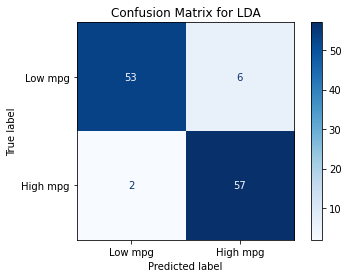

In [65]:
# Get confusion matrix
show_confusion_matrix(lda, 'LDA', test_X_std, test_Y, lda_pred)

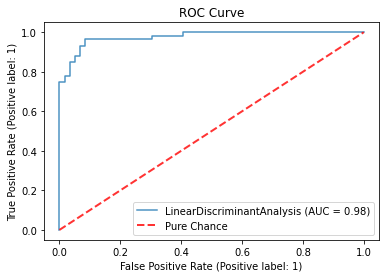

In [66]:
# Get ROC curve
show_ROC_curve(lda, test_X_std, test_Y)

## Model 2: QDA

In [67]:
# Train a QDA model and make prediction
qda = QuadraticDiscriminantAnalysis()
qda.fit(train_X_std, train_Y)
qda_pred = qda.predict(test_X_std)

+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.9322         |   0.9180    |   0.9492   |    0.9153     |
+---------+-----------------------+-------------+------------+---------------+


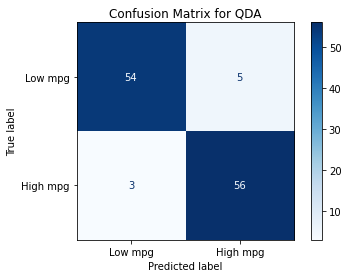

In [68]:
# Get confusion matrix
show_confusion_matrix(qda, 'QDA', test_X_std, test_Y, qda_pred)

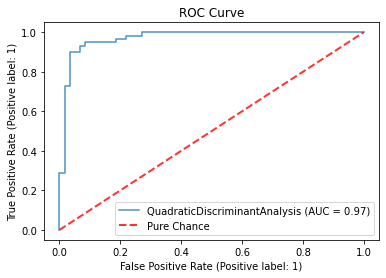

In [69]:
# Get ROC curve
show_ROC_curve(qda, test_X_std, test_Y)

## Model 3: Naive Bayes (Gaussian NB)

In [70]:
# Train a Gaussian NB model and make prediction
gnb = GaussianNB()
gnb.fit(train_X_std, train_Y)
gnb_pred = gnb.predict(test_X_std)

+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.9153         |   0.9153    |   0.9153   |    0.9153     |
+---------+-----------------------+-------------+------------+---------------+


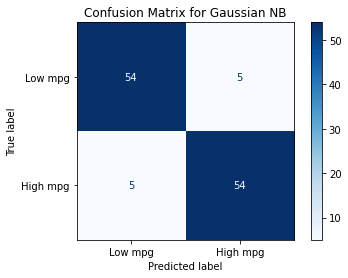

In [71]:
# Get confusion matrix
show_confusion_matrix(gnb, 'Gaussian NB', test_X_std, test_Y, gnb_pred)

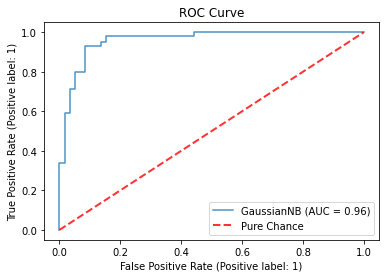

In [72]:
# Get ROC curve
show_ROC_curve(gnb, test_X_std, test_Y)

## Model 4: Logistic Regression

In [73]:
# Train a Logistic Regression model and make prediction
lg = LogisticRegression()
lg.fit(train_X_std, train_Y)
lg_pred = lg.predict(test_X_std)

+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.9068         |   0.9138    |   0.8983   |    0.9153     |
+---------+-----------------------+-------------+------------+---------------+


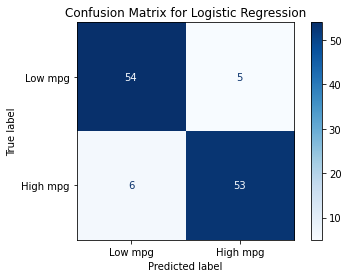

In [74]:
# Get confusion matrix
show_confusion_matrix(lg, 'Logistic Regression', test_X_std, test_Y, lg_pred)

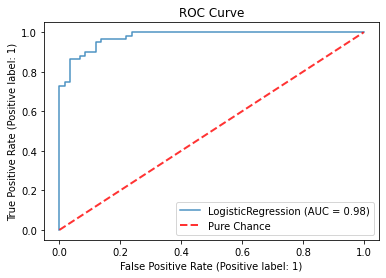

In [75]:
# Get ROC curve
show_ROC_curve(lg, test_X_std, test_Y)

## Model 5: KNN

In [76]:
# Perform parameter tuning to find the best K
# Accuracy is my criterion, because we have a balanced sample set and both classes are important
k_values = np.arange(1,15*2,2)
accu_mean = []
accu_std = []

In [77]:
# 5 fold CV for each K value
for k in k_values:
    temp_knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(temp_knn, train_X_std, train_Y, cv = 5, scoring = 'accuracy', n_jobs = -1)
    accu_mean.append(scores.mean())
    accu_std.append(scores.std())

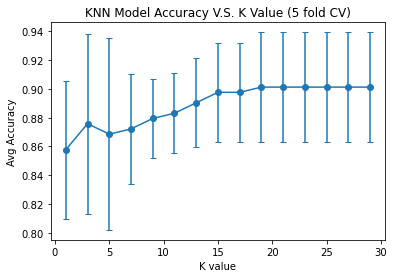

In [78]:
# Plot the tuning result. K = 19 is the best. 
plt.errorbar(x = k_values, y = accu_mean, yerr = accu_std, linestyle = '-', marker = 'o', capsize = 3)
plt.xlabel('K value')
plt.ylabel('Avg Accuracy')
plt.title('KNN Model Accuracy V.S. K Value (5 fold CV)')
plt.show()

In [79]:
# Train a KNN Classifier model with K = 19 and make prediction
knn = KNeighborsClassifier(n_neighbors = 19)
knn.fit(train_X_std, train_Y)
knn_pred = knn.predict(test_X_std)

+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.9322         |   0.9180    |   0.9492   |    0.9153     |
+---------+-----------------------+-------------+------------+---------------+


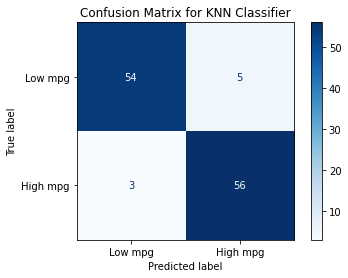

In [80]:
# Get confusion matrix
show_confusion_matrix(knn, 'KNN Classifier', test_X_std, test_Y, knn_pred)

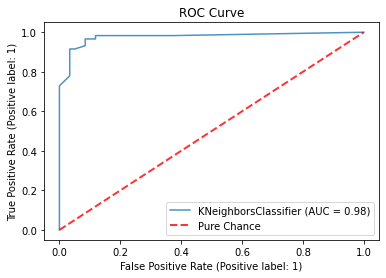

In [81]:
# Get ROC curve
show_ROC_curve(knn, test_X_std, test_Y)

## Model 6: PCA-KNN

In [82]:
# Perform PCA on training data, keeping all components
pca = PCA()
pca.fit(train_X_std)

PCA()

In [83]:
# Show the ratio of variance explained by each component
exp_var = {}
for i in range(8):
    exp_var['PC'+str(i+1)] = pca.explained_variance_ratio_[i]
exp_var_df = pd.DataFrame(exp_var, index = ['explained_var_ratio'])
print(tabulate(exp_var_df, headers = 'keys', tablefmt='grid', stralign='center'))


+---------------------+----------+---------+----------+-----------+-----------+-----------+------------+-----------+
|                     |      PC1 |     PC2 |      PC3 |       PC4 |       PC5 |       PC6 |        PC7 |       PC8 |
+=====================+==========+=========+==========+===========+===========+===========+============+===========+
| explained_var_ratio | 0.680573 | 0.13396 | 0.109349 | 0.0290034 | 0.0215309 | 0.0117863 | 0.00923582 | 0.0045622 |
+---------------------+----------+---------+----------+-----------+-----------+-----------+------------+-----------+


In [84]:
# First 3 principal components explained the majority of variance
# Let n_components = 1, 2, 3 and at the same time change k value to find the optimal combination

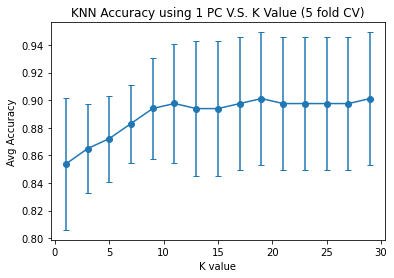

In [85]:
# Let n_components = 1 and try different K
pca = PCA(n_components = 1)
pca.fit(train_X_std)
train_X_reduced = pca.transform(train_X_std)

k_values = np.arange(1,15*2,2)
accu_mean = []
accu_std = []
# 5 fold CV for each K value
for k in k_values:
    temp_knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(temp_knn, train_X_reduced, train_Y, cv = 5, scoring = 'accuracy', n_jobs = -1)
    accu_mean.append(scores.mean())
    accu_std.append(scores.std())
# Plot the tuning result.
plt.errorbar(x = k_values, y = accu_mean, yerr = accu_std, linestyle = '-', marker = 'o', capsize = 3)
plt.xlabel('K value')
plt.ylabel('Avg Accuracy')
plt.title('KNN Accuracy using 1 PC V.S. K Value (5 fold CV)')
plt.show()

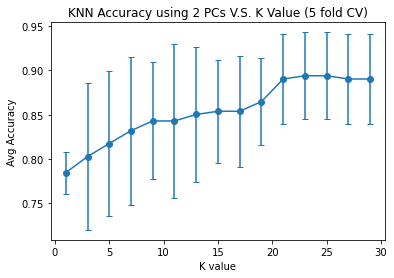

In [86]:
# Let n_components = 2 and try different K
pca = PCA(n_components = 2)
pca.fit(train_X_std)
train_X_reduced = pca.transform(train_X_std)

k_values = np.arange(1,15*2,2)
accu_mean = []
accu_std = []
# 5 fold CV for each K value
for k in k_values:
    temp_knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(temp_knn, train_X_reduced, train_Y, cv = 5, scoring = 'accuracy', n_jobs = -1)
    accu_mean.append(scores.mean())
    accu_std.append(scores.std())
# Plot the tuning result. 
plt.errorbar(x = k_values, y = accu_mean, yerr = accu_std, linestyle = '-', marker = 'o', capsize = 3)
plt.xlabel('K value')
plt.ylabel('Avg Accuracy')
plt.title('KNN Accuracy using 2 PCs V.S. K Value (5 fold CV)')
plt.show()

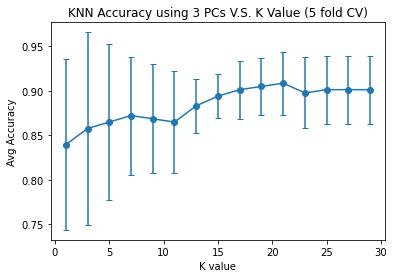

In [87]:
# Let n_components = 3 and try different K
pca = PCA(n_components = 3)
pca.fit(train_X_std)
train_X_reduced = pca.transform(train_X_std)

k_values = np.arange(1,15*2,2)
accu_mean = []
accu_std = []
# 5 fold CV for each K value
for k in k_values:
    temp_knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(temp_knn, train_X_reduced, train_Y, cv = 5, scoring = 'accuracy', n_jobs = -1)
    accu_mean.append(scores.mean())
    accu_std.append(scores.std())
# Plot the tuning result. K = 19 is the best.
plt.errorbar(x = k_values, y = accu_mean, yerr = accu_std, linestyle = '-', marker = 'o', capsize = 3)
plt.xlabel('K value')
plt.ylabel('Avg Accuracy')
plt.title('KNN Accuracy using 3 PCs V.S. K Value (5 fold CV)')
plt.show()

In [88]:
# Let n_components = 3 to perform PCA
pca = PCA(n_components = 1)
pca.fit(train_X_std)
train_X_reduced = pca.transform(train_X_std)
test_X_reduced = pca.transform(test_X_std)

In [89]:
# Train a KNN Classifier model with K = 21 and make prediction
pca_knn = KNeighborsClassifier(n_neighbors = 21)
pca_knn.fit(train_X_reduced, train_Y)
pca_knn_pred = pca_knn.predict(test_X_reduced)

+---------+-----------------------+-------------+------------+---------------+
|         |       Accuracy        |  Precision  |   Recall   |  Specificity  |
+=========+=======================+=============+============+===============+
| Formula | (TN+TP)/(TN+TP+FN+FP) | TP/(TP+FP)  | TP/(TP+FN) |  TN/(TN+FP)   |
+---------+-----------------------+-------------+------------+---------------+
|  Value  |        0.8983         |   0.9123    |   0.8814   |    0.9153     |
+---------+-----------------------+-------------+------------+---------------+


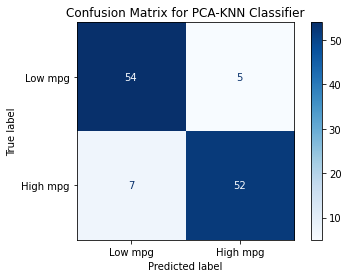

In [90]:
# Get confusion matrix
show_confusion_matrix(pca_knn, 'PCA-KNN Classifier', test_X_reduced, test_Y, pca_knn_pred)

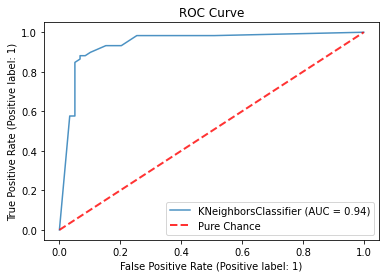

In [91]:
# Get ROC curve
show_ROC_curve(pca_knn, test_X_reduced, test_Y)

# Monte Carlo Cross Validation

## Combine train_final and test_final

In [92]:
# This is the dataset for Monte Carlo CV
data_final = pd.concat([train_final, test_final])

In [93]:
# Create a dictionary to store CV result, which is the accuracy
cv = {'LDA':[], 'QDA':[], 'NB':[], 'Logistic':[], 'KNN':[], 'PCA-KNN':[]}

## CV for LDA

In [94]:
for i in tqdm(range(100)):
    # Random sample training and testing set
    cv_test = data_final.groupby('mpg01', group_keys = False).apply(lambda x: x.sample(frac = 0.3))
    cv_train = data_final.drop(labels = cv_test.index)

    cv_train_X = cv_train.drop(['mpg', 'mpg01'], axis = 1)
    cv_train_Y = cv_train['mpg01']

    cv_test_X = cv_test.drop(['mpg', 'mpg01'], axis = 1)
    cv_test_Y = cv_test['mpg01']

    # Standardize data
    ct.fit(cv_train_X)
    cv_train_X_std = ct.transform(cv_train_X)
    cv_test_X_std = ct.transform(cv_test_X)

    # Fit the model
    cv_lda = LinearDiscriminantAnalysis()
    cv_lda.fit(cv_train_X_std, cv_train_Y)
    cv_lda_pred = cv_lda.predict(cv_test_X_std)

    # Calculate Accuracy
    
    cf_matrix = confusion_matrix(cv_test_Y, cv_lda_pred)

    true_negatives = cf_matrix[0][0]
    false_negatives = cf_matrix[1][0]
    true_positives = cf_matrix[1][1]
    false_positives = cf_matrix[0][1]

  
    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)

    cv['LDA'].append(accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

## CV for QDA

In [95]:
for i in tqdm(range(100)):
    # Random sample training and testing set
    cv_test = data_final.groupby('mpg01', group_keys = False).apply(lambda x: x.sample(frac = 0.3))
    cv_train = data_final.drop(labels = cv_test.index)

    cv_train_X = cv_train.drop(['mpg', 'mpg01'], axis = 1)
    cv_train_Y = cv_train['mpg01']

    cv_test_X = cv_test.drop(['mpg', 'mpg01'], axis = 1)
    cv_test_Y = cv_test['mpg01']

    # Standardize data
    ct.fit(cv_train_X)
    cv_train_X_std = ct.transform(cv_train_X)
    cv_test_X_std = ct.transform(cv_test_X)

    # Fit the model
    cv_qda = QuadraticDiscriminantAnalysis()
    cv_qda.fit(cv_train_X_std, cv_train_Y)
    cv_qda_pred = cv_qda.predict(cv_test_X_std)

    # Calculate Accuracy
    
    cf_matrix = confusion_matrix(cv_test_Y, cv_qda_pred)

    true_negatives = cf_matrix[0][0]
    false_negatives = cf_matrix[1][0]
    true_positives = cf_matrix[1][1]
    false_positives = cf_matrix[0][1]

  
    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)

    cv['QDA'].append(accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

## CV for Naive Bayes

In [96]:
for i in tqdm(range(100)):
    # Random sample training and testing set
    cv_test = data_final.groupby('mpg01', group_keys = False).apply(lambda x: x.sample(frac = 0.3))
    cv_train = data_final.drop(labels = cv_test.index)

    cv_train_X = cv_train.drop(['mpg', 'mpg01'], axis = 1)
    cv_train_Y = cv_train['mpg01']

    cv_test_X = cv_test.drop(['mpg', 'mpg01'], axis = 1)
    cv_test_Y = cv_test['mpg01']

    # Standardize data
    ct.fit(cv_train_X)
    cv_train_X_std = ct.transform(cv_train_X)
    cv_test_X_std = ct.transform(cv_test_X)

    # Fit the model
    cv_gnb = GaussianNB()
    cv_gnb.fit(cv_train_X_std, cv_train_Y)
    cv_gnb_pred = cv_gnb.predict(cv_test_X_std)

    # Calculate Accuracy
    
    cf_matrix = confusion_matrix(cv_test_Y, cv_gnb_pred)

    true_negatives = cf_matrix[0][0]
    false_negatives = cf_matrix[1][0]
    true_positives = cf_matrix[1][1]
    false_positives = cf_matrix[0][1]

  
    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)

    cv['NB'].append(accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

## CV for Logistic Regression

In [97]:
for i in tqdm(range(100)):
    # Random sample training and testing set
    cv_test = data_final.groupby('mpg01', group_keys = False).apply(lambda x: x.sample(frac = 0.3))
    cv_train = data_final.drop(labels = cv_test.index)

    cv_train_X = cv_train.drop(['mpg', 'mpg01'], axis = 1)
    cv_train_Y = cv_train['mpg01']

    cv_test_X = cv_test.drop(['mpg', 'mpg01'], axis = 1)
    cv_test_Y = cv_test['mpg01']

    # Standardize data
    ct.fit(cv_train_X)
    cv_train_X_std = ct.transform(cv_train_X)
    cv_test_X_std = ct.transform(cv_test_X)

    # Fit the model
    cv_lg = LogisticRegression()
    cv_lg.fit(cv_train_X_std, cv_train_Y)
    cv_lg_pred = cv_lg.predict(cv_test_X_std)

    # Calculate Accuracy
    
    cf_matrix = confusion_matrix(cv_test_Y, cv_lg_pred)

    true_negatives = cf_matrix[0][0]
    false_negatives = cf_matrix[1][0]
    true_positives = cf_matrix[1][1]
    false_positives = cf_matrix[0][1]

  
    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)

    cv['Logistic'].append(accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

## CV for KNN

In [98]:
for i in tqdm(range(100)):
    # Random sample training and testing set
    cv_test = data_final.groupby('mpg01', group_keys = False).apply(lambda x: x.sample(frac = 0.3))
    cv_train = data_final.drop(labels = cv_test.index)

    cv_train_X = cv_train.drop(['mpg', 'mpg01'], axis = 1)
    cv_train_Y = cv_train['mpg01']

    cv_test_X = cv_test.drop(['mpg', 'mpg01'], axis = 1)
    cv_test_Y = cv_test['mpg01']

    # Standardize data
    ct.fit(cv_train_X)
    cv_train_X_std = ct.transform(cv_train_X)
    cv_test_X_std = ct.transform(cv_test_X)

    # Fit the model
    cv_knn = KNeighborsClassifier(n_neighbors = 19)
    cv_knn.fit(cv_train_X_std, cv_train_Y)
    cv_knn_pred = cv_knn.predict(cv_test_X_std)

    # Calculate Accuracy
    
    cf_matrix = confusion_matrix(cv_test_Y, cv_knn_pred)

    true_negatives = cf_matrix[0][0]
    false_negatives = cf_matrix[1][0]
    true_positives = cf_matrix[1][1]
    false_positives = cf_matrix[0][1]

  
    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)

    cv['KNN'].append(accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

## CV for PCA-KNN

In [99]:
for i in tqdm(range(100)):
    # Random sample training and testing set
    cv_test = data_final.groupby('mpg01', group_keys = False).apply(lambda x: x.sample(frac = 0.3))
    cv_train = data_final.drop(labels = cv_test.index)

    cv_train_X = cv_train.drop(['mpg', 'mpg01'], axis = 1)
    cv_train_Y = cv_train['mpg01']

    cv_test_X = cv_test.drop(['mpg', 'mpg01'], axis = 1)
    cv_test_Y = cv_test['mpg01']

    # Standardize data
    ct.fit(cv_train_X)
    cv_train_X_std = ct.transform(cv_train_X)
    cv_test_X_std = ct.transform(cv_test_X)
    
    # Perform PCA to reduce data
    cv_pca = PCA(n_components = 1)
    cv_pca.fit(cv_train_X_std)
    cv_train_X_reduced = cv_pca.transform(cv_train_X_std)
    cv_test_X_reduced = cv_pca.transform(cv_test_X_std)

    # Fit the model
    cv_pca_knn = KNeighborsClassifier(n_neighbors = 11)
    cv_pca_knn.fit(cv_train_X_reduced, cv_train_Y)
    cv_pca_knn_pred = cv_pca_knn.predict(cv_test_X_reduced)
    # Calculate Accuracy
    
    cf_matrix = confusion_matrix(cv_test_Y, cv_pca_knn_pred)

    true_negatives = cf_matrix[0][0]
    false_negatives = cf_matrix[1][0]
    true_positives = cf_matrix[1][1]
    false_positives = cf_matrix[0][1]

  
    accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)

    cv['PCA-KNN'].append(accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

## Summarize CV result

In [100]:
cv_df = pd.DataFrame(cv)

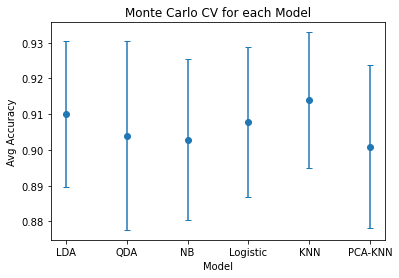

In [101]:
names = cv_df.columns
mean = cv_df.mean()
std = cv_df.std()

plt.errorbar(x = names, y = mean, yerr = std, linestyle='None', marker='o', capsize = 3)
plt.xlabel('Model')
plt.ylabel('Avg Accuracy')
plt.title('Monte Carlo CV for each Model')

plt.show()